# **Withdrawal Percentage**

## Table of contents<a id='toc0_'></a>    
- [Introduction](#toc1_2_)    
- [Cleaning the Data](#toc1_3_)    
- [Working with the Data](#toc1_4_)    
	- [Calculating Total Deposit and Withdrawal](#toc1_4_1_)    
    - [Withdrawal Percentage](#toc1_4_2_)    
- [Visualization](#toc1_5_)    
- [Conclusion](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_2_'></a>[Introduction](#toc0_)

In this project, I will be working with several datasets to analyze the withdrawal percentage in a trading broker company during August 2022 until July 2023. The brokerage wanted to see <u>the percentage of clients that have withdrawn 100% or more from their total deposit</u>. Moreover, I will need to <u>group the clients based on the city they are from</u>, so the trading broker can evaluate the performance of each branch.

I will use pandas to work with the data and I will visualize the final data by using matplotlib.

In [80]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

In [81]:
#converting the csv files to dataframes by using pandas
acc = pd.read_csv('Accounts.csv')
ct = pd.read_csv('Closed Trades (Randomized).csv')
dw = pd.read_csv('Deposit and Withdrawal.csv')

## <a id='toc1_3_'></a>[Cleaning the Data](#toc0_)

I created a function to convert the date of the datasets and change the format.

In [82]:
def convert_datetime(df):
    df = pd.to_datetime(
            df,
            format='%d-%b-%y')
    return df

In [83]:
#changing the datatype of Login from float to int
dw['Login'] = pd.to_numeric(dw['Login'], errors='coerce').fillna(0).astype(int)
#changing the dates to date format
ct['Open Date'] = convert_datetime(ct['Open Date'])
ct['Close Date'] = convert_datetime(ct['Close Date'])
dw['Date'] = convert_datetime(dw['Date'])


## <a id='toc1_4_'></a>[Working with the Data](#toc0_)

Firstly, I need to filter the accounts that are made within the time range (Aug 2022 - Jul 2023). I did this by passing the time range and  filtering based on the comment 'Initial' (Ini), which indicates the instance where the clients lodge in their first deposit into their account.

In [84]:
#filtering new Accounts that are made between 31 July 2022 and 1 Aug 2023
time_frame_1='2022-07-31'
time_frame_2='2023-08-01'
new_acc_Aug22_Jul23= dw[(dw['Date']> time_frame_1)&(dw['Date']< time_frame_2)&(dw['Comment'].isin(['Ini']))]

Then I make a variable to store the filtered Deposit and Withdrawal dataframe to only contain new accounts made during Aug 2022 - Jul 2023.

In [85]:
#filtering the DW dataframe based on the login from the new_acc dataframe
dw_time_framed=dw[dw['Login'].isin(new_acc_Aug22_Jul23['Login'])]

### <a id='toc1_4_1_'></a>[Calculating Total Deposit and Withdrawal](#toc0_)

I calculated the deposit of each account by adding the initial and add margin that the client did during the time period. I also calculated the total withdrawal that is made per account.

In [86]:
#calculating the total deposit for accounts made between Aug 22 - Jul 23
deposit = dw_time_framed[(dw_time_framed['Comment'] == 'Ini') | (dw_time_framed['Comment'] == 'Add')]\
    .groupby(['Login']).agg({'Amount':'sum'})

#calculating the total withdrawal for accounts made between Aug 22 - Jul 23
wit = dw_time_framed[dw_time_framed['Comment'] == 'Wit']\
    .groupby(['Login']).agg({'Amount':'sum'})

I combined the two dataframes into one by Login and clean the data as there are some accounts that have never withdrawn, so I fill the NA rows with 0.

In [87]:
#combining the deposit and wit dataframes into one dataframe called margin_table based on Login
margin_table=deposit.merge(wit, how='left', on='Login').rename(columns={"Amount_x":"Total Deposit","Amount_y":"Total Withdrawal"})
margin_table['Total Withdrawal'] = margin_table['Total Withdrawal'].fillna(0)

### <a id='toc1_4_2_'></a>[Withdrawal Percentage](#toc0_)

I made a new column to calculate the withdrawal percentage by dividing the total withdrawal and total deposit.

In [88]:
#calculating Withdrawal Percentage and adding it to margin_table
margin_table['Withdrawal Percentage'] = margin_table['Total Withdrawal'] / margin_table['Total Deposit'] * -1

As I need data about the city each accounts is from, I merged the Accounts dataframe that contains the 'City' column and add it into the margin_table. Then I made a new variable that will store the grouped margin table based on city to see how many accounts are there from each city.

In [89]:
margin_table=margin_table.merge(acc, how='left', on='Login')
margin_table_city = margin_table.groupby(['City']).agg({'Login':'count'})

To separate the accounts that have traded and have never traded, I can use the data from the Closed Trade dataset as it contains information about the accounts that have closed their position, hence they have traded. \
I grouped the Closed Trades dataset based on Login and sum all the Profit. Then I merge it to the margin table based on Login. There will be empty cells in the Profit column that indicates the client have opened an account but have never traded, and withdrawn all of their deposit. 

In [90]:
trading = ct.groupby(['Login']).agg({'Profit':'sum'})
margin_table=margin_table.merge(trading, how='left', on='Login')
margin_table['Profit'] = margin_table['Profit'].fillna("Has never traded")

Then I filter the margin table for accounts that have traded and withdrawn 100% or more from their total deposit.
Then I grouped the table based on City to see the amount of clients in that city that fit into this category.

In [91]:
#filtering the accounts that have witndrawn 100% of their total deposit and have traded.
withdrawed_100_traded=margin_table[(margin_table['Withdrawal Percentage']>=1)&(margin_table['Profit']!='Has never traded')]
withdrawed_100_traded_city = withdrawed_100_traded.groupby(['City']).agg({'Login':'count'})

To see the total percentage of clients that have withdrawn per city, I need the data of the total clients in each city. So I merged the total clients per City from the margin_table_city dataframe with withdrawed_100_traded_city dataframe. \
Then I calculated the percentage by simply dividing the the clients that have withdrawn and the total clients in every city.

In [92]:
margin_percentage = margin_table_city.merge(withdrawed_100_traded_city, how='left', on='City').rename(columns={"Login_x":"Total Customer","Login_y":"Total Withdrawal"})
margin_percentage['Withdraw Percentage'] = margin_percentage['Total Withdrawal'] / margin_percentage['Total Customer'] * 100
margin_percentage=margin_percentage.reset_index()
margin_percentage

,City,Total Customer,Total Withdrawal,Withdraw Percentage
0,A,144,14,9.722222
1,B,165,22,13.333333
2,C,11,2,18.181818
3,D,317,33,10.410095
4,G,27,6,22.222222
5,J,113,8,7.079646
6,K,110,16,14.545455
7,M,2210,215,9.728507
8,N,93,13,13.978495
9,O,111,19,17.117117


## <a id='toc1_5_'></a>[Visualization](#toc0_)

To visualize the final dataframe, I use matplotlib and I decided to visualize it with a bar chart.\
I pass in the parameter from the dataframe with 'City' as the X-axis and 'Withdraw Percentage' as the Y-axis.

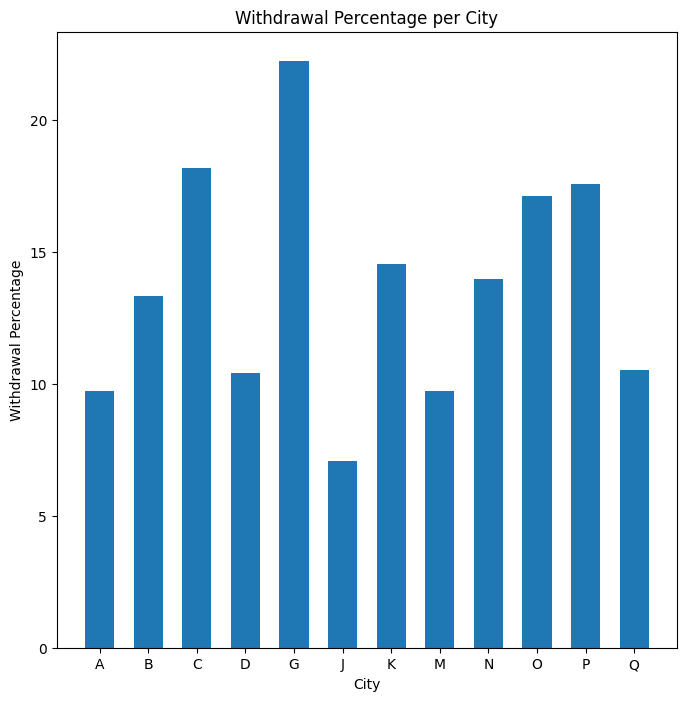

In [93]:
fig = plt.figure(figsize = (8, 8))
plt.bar(margin_percentage['City'], margin_percentage['Withdraw Percentage'],
        width=0.6)

plt.xlabel("City")
plt.ylabel("Withdrawal Percentage")
plt.title("Withdrawal Percentage per City")
plt.show()

## <a id='toc1_6_'></a>[Conclusion](#toc0_)

Based on the graph, I can conclude that **City 'G' has the most percentage of clients that have traded and withdrawn 100% of their total deposit** while City 'J' has the least percentage of clients that have withdrawn. \
I can suggest the brokerage that <u>City G might need to improve their retention</u> to maintain the clients and prevent them from withdrawing or closing their accounts. 